In [140]:
import pandas as pd
import numpy as np
import os


**Collect the data**

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ketakichalke/ppe-kit-detection-construction-site-workers")

print("Path to dataset files:", path)

DATASET_PATH = path

Path to dataset files: C:\Users\-\.cache\kagglehub\datasets\ketakichalke\ppe-kit-detection-construction-site-workers\versions\1


The dataset contains a "None" class, which does not bring any value to the final model. 
The decision is to drop it

In [144]:
from scripts import clean_labels

data_path = os.path.join(DATASET_PATH, 'data')

for split in ['train', 'val', 'test']:
    print(f"Cleaning {split} labels...")
    clean_labels(split, data_path)

print("Done")


Cleaning train labels...
Cleaned image100.txt: removed 8 lines (kept only non-None)
Cleaned image1000.txt: removed 2 lines (kept only non-None)
Cleaned image1001.txt: removed 8 lines (kept only non-None)
Cleaned image1002.txt: removed 8 lines (kept only non-None)
Cleaned image1004.txt: removed 8 lines (kept only non-None)
Cleaned image1005.txt: removed 4 lines (kept only non-None)
Cleaned image1006.txt: removed 5 lines (kept only non-None)
Cleaned image1008.txt: removed 3 lines (kept only non-None)
Cleaned image101.txt: removed 6 lines (kept only non-None)
Cleaned image1011.txt: removed 8 lines (kept only non-None)
Cleaned image1012.txt: removed 8 lines (kept only non-None)
Cleaned image1013.txt: removed 8 lines (kept only non-None)
Cleaned image1015.txt: removed 8 lines (kept only non-None)
Cleaned image1016.txt: removed 9 lines (kept only non-None)
Cleaned image1017.txt: removed 8 lines (kept only non-None)
Cleaned image1018.txt: removed 8 lines (kept only non-None)
Cleaned image102.

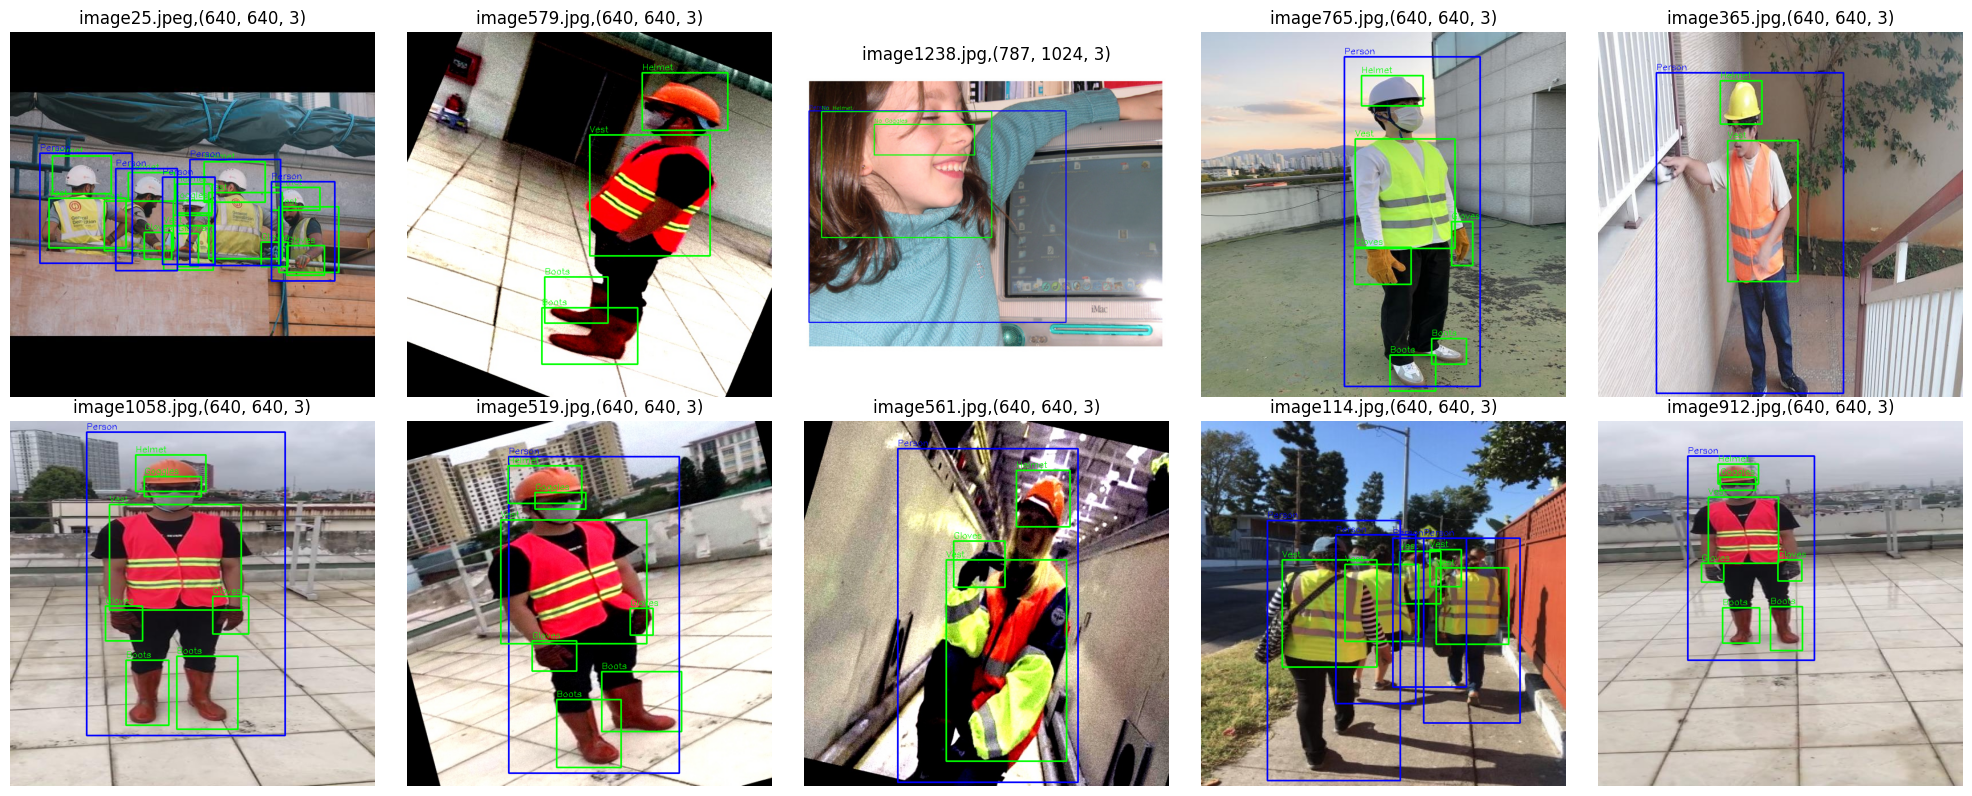

In [314]:
import cv2
import matplotlib.pyplot as plt

CLASS_MAP = {
    0: 'Helmet',
    1: 'Gloves',
    2: 'Vest',
    3: 'Boots',
    4: 'Goggles',
    5: 'None',
    6: 'Person',
    7: 'No Helmet',
    8: 'No Goggles',
    9: 'No Gloves',
    10: 'No Boots'
}

def visualize_batch_on_grid(split='train', num_images=10):
    images_dir = os.path.join(DATASET_PATH, 'data', 'images', split)
    labels_dir = os.path.join(DATASET_PATH, 'data', 'labels', split)

    all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        num_images = len(all_images)

    sample_images = np.random.choice(all_images, num_images, replace=False)

    # Set up the plot grid (2 rows, 5 columns for 10 images)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    axes = axes.flatten()

    for idx, sample_image_name in enumerate(sample_images):
        sample_image_path = os.path.join(images_dir, sample_image_name)

        if not os.path.exists(sample_image_path):
            print(f"Image not found: {sample_image_name}")
            continue

        # Load image
        sample_image = cv2.imread(sample_image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Load label
        label_path = os.path.join(labels_dir, sample_image_name.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        if not os.path.exists(label_path):
            print(f"Label not found for {sample_image_name}")
            continue

        h, w, _ = sample_image.shape

        # Draw bounding boxes
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split(' ')
                class_id, x_center, y_center, width, height = map(float, parts)

                x1 = int((x_center - width / 2) * w)
                x2 = int((x_center + width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                y2 = int((y_center + height / 2) * h)

                label = CLASS_MAP.get(int(class_id), 'Unknown')
                colour = (0, 0, 255) if label == 'Person' else (255, 0, 0) if 'No ' in label.lower() else (0, 255, 0)

                cv2.rectangle(sample_image, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(sample_image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour, 1)

        # Plot each image in the grid
        axes[idx].imshow(sample_image)
        axes[idx].set_title(f"{sample_image_name},{sample_image.shape}")
        axes[idx].axis('off')

    # Hide unused subplots if there were fewer than 10 images
    for i in range(len(sample_images), 10):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example usage
visualize_batch_on_grid(split='train', num_images=10)